(activity10)=
# Activity 10: Propensity Scores for Overlap and Balancing

**2025-10-08**

---

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from ipywidgets import interact_manual
from ipywidgets import widgets


rng = np.random.default_rng(42)

# Part 1: Distribution of covariates under true randomization

For the growth mindset intervention, we saw that the `success_expect` covariate was associated with the intervention. What should the distribution of `success_expect` look like under true randomization (coin flips)? And does it matter if the coin flips are "biased" (not 50% heads, 50% tails)?

First, let's simulate a distribution of `success_expect` under true randomization. Begin by generating some data that represents `success_expect`, which takes on integer values between 1 and 7. Use the [rng.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html) function to generate 10,000 samples from a uniform distribution over the integers 1 through 7.

In [17]:
help(rng.choice)

Help on method choice in module numpy.random._generator:

choice(a, size=None, replace=True, p=None, axis=0, shuffle=True) method of numpy.random._generator.Generator instance
    choice(a, size=None, replace=True, p=None, axis=0, shuffle=True)

    Generates a random sample from a given array

    Parameters
    ----------
    a : {array_like, int}
        If an ndarray, a random sample is generated from its elements.
        If an int, the random sample is generated from np.arange(a).
    size : {int, tuple[int]}, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn from the 1-d `a`. If `a` has more
        than one dimension, the `size` shape will be inserted into the
        `axis` dimension, so the output ``ndim`` will be ``a.ndim - 1 +
        len(size)``. Default is None, in which case a single value is
        returned.
    replace : bool, optional
        Whether the sample is with or without replacement. Defa

In [18]:
n_samples = 10000
sim_success_expect = rng.choice(a=np.arange(1, 8), size=n_samples)

Next, generate random treatment assignments for each sample using the `rng.choice` function. For now, assume the probability of treatment is 0.5, that is:

$$ 
P(T=1) = 0.5 
$$

In [19]:
p_treat = 0.5
# p needs to be a list of probabilities for each outcome: [0, 1]
p = [1-p_treat, p_treat]
sim_treat = rng.choice(a=[0, 1], size=n_samples, p=p)

Let's now plot the distribution of treatment for each `sim_success_expect` level. We'll do this by creating a dataframe with the two columns `sim_success_expect` and `sim_treat`, and then using sns.barplot to plot the distribution of `sim_treat` for each `sim_success_expect` level.

Call [sns.barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) with the x and y parameters set to `sim_success_expect` and `sim_treat`, respectively.

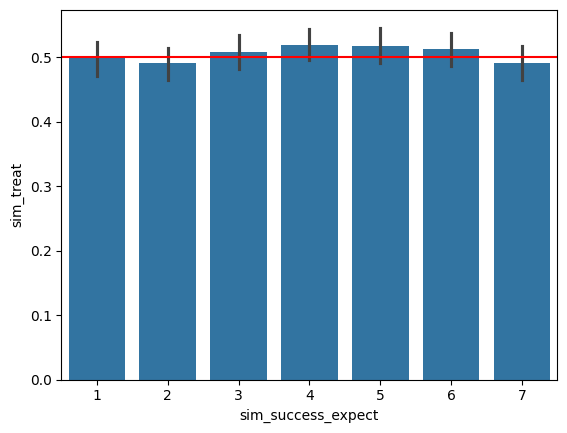

In [20]:
sim_df = pd.DataFrame({
    'sim_success_expect': sim_success_expect, 
    'sim_treat': sim_treat
})

sim_df.head()
# TODO sns.barplot
sns.barplot(x='sim_success_expect', y='sim_treat', data=sim_df)
# TODO horizontal line corresponding to p_treat
plt.axhline(y=p_treat, label="true probability of treatment", color="red")

The black vertical lines on each bar represnt a bootstrapped confidence interval for the proportion of treatment in each `sim_success_expect` level. On your plot above, add a horizontal line using `plt.axhline` at `y=p_treat` to represent the true probability of treatment. The observed probability of treatment shouldn't deviate significantly from the true probability of treatment for any of the `sim_success_expect` values.

Finally, let's explore different different probabilities of treatment. Copy your code from the above three cells that created your barplot into the `plot_treatment_distribution` function below, and add an `interact_manual` decorator that lets you change `p_treat`. 

Does the probability of treatment change the distribution of treated units among the `sim_success_expect` values? 

In [21]:
# TODO an interact_manual
@interact_manual(p_treat=np.arange(0, 1, 0.1))
def plot_treatment_distribution(p_treat):
    n_samples = 10000
    sim_success_expect = rng.choice(a=np.arange(1, 8), size=n_samples)
    p = [1-p_treat, p_treat]
    sim_treat = rng.choice(a=[0, 1], size=n_samples, p=p)

    sim_df = pd.DataFrame({
    'sim_success_expect': sim_success_expect, 
    'sim_treat': sim_treat
    })
    
    sim_df.head()
    # TODO sns.barplot
    sns.barplot(x='sim_success_expect', y='sim_treat', data=sim_df)
    # TODO horizontal line corresponding to p_treat
    plt.axhline(y=p_treat, label="true probability of treatment", color="red")

interactive(children=(Dropdown(description='p_treat', options=(np.float64(0.0), np.float64(0.1), np.float64(0.…

# Part 2: Fitting a Propensity Score

Let's now estimate a propensity score for the learning mindsets data. As a reminder from Monday's lecture, the columns we'll look at are:

- `intervention`: whether the student received the intervention (1) or not (0)
- `success_expect`: student prior mindset about their ability to succeed in school (higher values indicate a stronger belief in their ability to succeed)
- `frst_in_family`: whether the student would be the first in their family to attend college (1) or not (0)
- `gender`: student's self-reported gender
- `school_urbanicity`: categorical variable corresponding to the urbanicity of the school the student attends, e.g. urban, suburban, rural
- `achievement_score`: the student's future grade achievement, standardized such that 0 is the mean and it has a standard deviation of 1


The way we'll do this is by fitting a logistic regression model, which allows us estimate the following:

$$
P(T=1 \mid X) = E[T \mid X] = e(X)
$$

Like with linear regression, this can extend to multiple covariates, such as:

$$
P(T=1 \mid X_1, X_2, X_3, X_4) = E[T \mid X_1, X_2, X_3, X_4]
$$


In statmodels, we just need to specify the formula string `'T ~1 + X1 + X2 + X3 + X4'` and pass the dataframe to `smf.logit` instead of `smf.ols` to fit a logistic regression model:



```python
model = smf.logit('T ~ 1 + X1 + X2 + X3 + X4', data=data).fit()
```

Fit a propensity score model predicting `intervention` and our four covariates from Tuesday's lecture (`success_expect`, `gender`, `frst_in_family`, `school_urbanicity`).

One additional consideration is that `gender` and `school_urbanicity` are categorical variables. We can indicate to `smf.logit` that these variables are categorical by wrapping the variables in `C()` in the formula string. For example, if we wanted to fit a model with `X1` and `X2` as categorical variables, we would write:

```python
model = smf.logit('T ~ 1 + C(X1) + C(X2) + X3 + X4', data=data).fit()
```

In [22]:
# load the learning_mindset data again
learning_df = pd.read_csv("~/COMSC-341CD/data/learning_mindset.csv")

In [23]:
# TODO fit a propensity score model
formula = 'intervention ~ 1 + success_expect + frst_in_family + C(gender) + C(school_urbanicity)'
propensity_model = smf.logit(formula=formula, data=learning_df).fit()
#propensity_model = smf.logit(formula=formula, data=learning_df).fit()

Optimization terminated successfully.
         Current function value: 0.628017
         Iterations 5


We can then add the predicted propensity scores as a column to analyze along with the rest of the data. Run the cell below to generate predicted propensity scores and add them to the learning_df:

In [24]:
pred_propensity_scores = propensity_model.predict(learning_df)
learning_df['propensity_score'] = pred_propensity_scores

A quick check for whether we've fit the propensity score correctly is to verify that the average propensity score is equal to the probability of treatment in the dataset:

In [25]:
p_treat = learning_df['intervention'].mean()

assert np.isclose(learning_df['propensity_score'].mean(), p_treat, atol=0.01), "The average propensity score is not equal to the probability of treatment"

Propensity score give us a lot of flexibility in visualizing confounding issues. For example, we can generate the same barplot we made in part 1 with `success_expect` on the x-axis, but with the `propensity_score` on the y-axis for our `learning_df` dataset.

What do you observe about the relationship between `success_expect` and `propensity_score`?

**Your response:** [pollev.com/tliu](https://pollev.com/tliu)

<Axes: xlabel='success_expect', ylabel='propensity_score'>

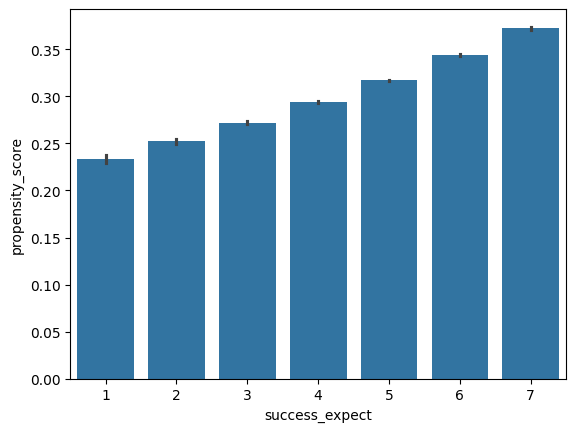

In [26]:
# TODO a barplot of x=success_expect vs y=propensity_score
sns.barplot(x='success_expect', y='propensity_score', data=learning_df)

# Part 3: Propensity scores for exploring covariate distribution

In Project 1, we're plotting the distribution of covariates of treated and control units to visually verify that the covariates were balanced between the two groups.

The propensity score is a convenient way check whether **all** the covariates we want to control for are balanced between the two groups.

Run the cell below to fit a propensity score model for our simulated data from Part 1. Then plot the distribution of propensity scores for the treated and control units by creating a [sns.kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) with the x-axis as the `propensity_score` and the hue as the `sim_treat` variable -- optionally setting `cumulative=True` to plot the cumulative distribution. The distributions should approximately match since we simulated a randomized experiment:

Optimization terminated successfully.
         Current function value: 0.693081
         Iterations 3


<Axes: xlabel='propensity_score', ylabel='Density'>

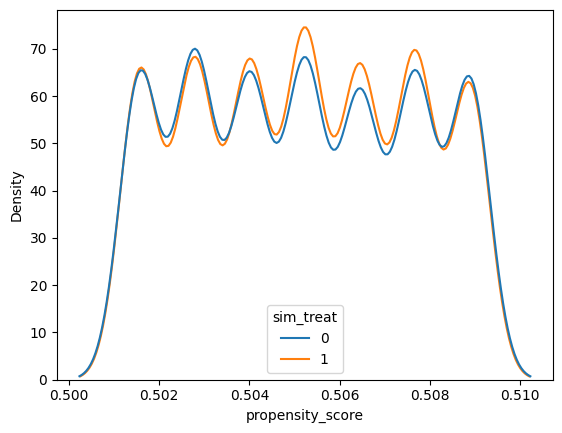

In [27]:
sim_propensity_model = smf.logit('sim_treat ~ 1 + sim_success_expect', data=sim_df).fit()
sim_propensity_scores = sim_propensity_model.predict(sim_df)
sim_df['propensity_score'] = sim_propensity_scores

# TODO kdeplot
sns.kdeplot(x='propensity_score', hue='sim_treat', data=sim_df)

Now, create the same plot for our `learning_df` dataset, setting the hue to `intervention` and `x` to `propensity_score`.

Differences in the distributions suggest that the covariates are not balanced between the two groups -- in other words, there is confounding among the covariates we've included in the propensity score model.


<Axes: xlabel='propensity_score', ylabel='Density'>

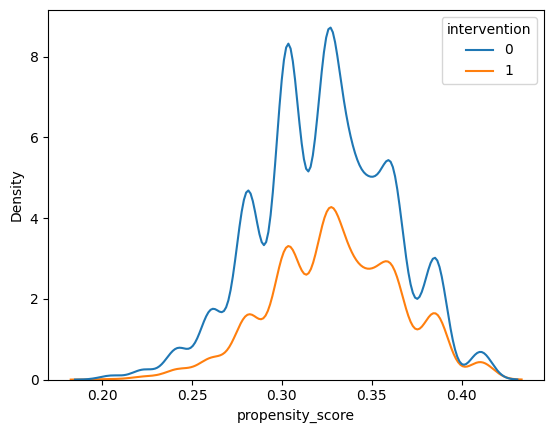

In [28]:
sns.kdeplot(x='propensity_score', data=learning_df, hue='intervention')

<Axes: xlabel='propensity_score', ylabel='Count'>

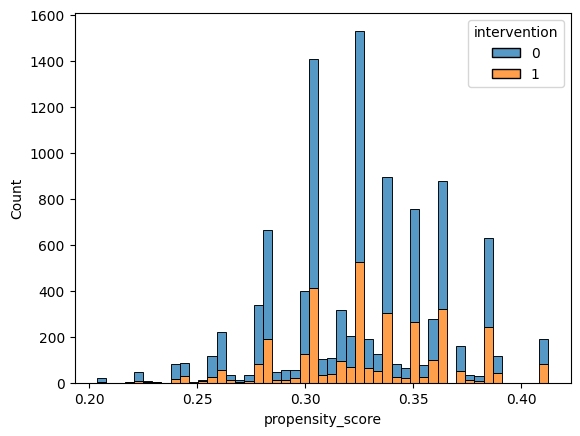

In [31]:
sns.histplot(x='propensity_score', data=learning_df, hue='intervention', multiple='stack')

This type of density plot of the propensity score also allows us to check positivity -- if there are regions of the propensity score where there are only treated or only control units, then there is a positivity violation.

Does there appear to be any obvious regions where there are only treated or only control units? What about regions where there are few treated or control units?

**Your response:** [pollev.com/tliu](https://pollev.com/tliu)

# Part 4: Propensity scores as a balancer 

Now that we have the propensity score distilling high-dimensional covariates into a single number, binning the data by the propensity score becomes a viable strategy for balancing the covariates.

Run the cell below to bin the data by the propensity score using the [pd.cut](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) function, producing a new column `propensity_score_bin` in the `learning_df` dataframe.

In [32]:
n_bins = 5
learning_df['propensity_score_bin'] = pd.cut(learning_df['propensity_score'], bins=n_bins)

# view the bins created by pd.cut
print(learning_df['propensity_score_bin'].unique())

[(0.287, 0.329], (0.245, 0.287], (0.329, 0.371], (0.371, 0.412], (0.203, 0.245]]
Categories (5, interval[float64, right]): [(0.203, 0.245] < (0.245, 0.287] < (0.287, 0.329] < (0.329, 0.371] < (0.371, 0.412]]


Then, perform a groupby with `by='[propensity_score_bin', 'intervention']`, and calculate the mean of the given columns on the grouped data.

Are there any of the columns that are significantly different between the $T=1$ and $T=0$ groups for each propensity score bin? If so, how do you interpret this?

**Your response:** [pollev.com/tliu](https://pollev.com/tliu)


In [34]:
# TODO group by propensity score bin and intervention, and calculate the mean of the columns on the grouped data
columns = ['success_expect', 'frst_in_family', 'school_urbanicity', 'gender', 'achievement_score']
learning_df.groupby(by=['propensity_score_bin', 'intervention'])[columns].mean()

/tmp/ipykernel_1633596/648158888.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  learning_df.groupby(by=['propensity_score_bin', 'intervention'])[columns].mean()


success_expect  frst_in_family  \
propensity_score_bin intervention                                   
(0.203, 0.245]       0                   1.966667        0.988889   
                     1                   1.950000        0.983333   
(0.245, 0.287]       0                   4.013749        0.957837   
                     1                   3.984694        0.954082   
(0.287, 0.329]       0                   5.213038        0.876008   
                     1                   5.270698        0.883369   
(0.329, 0.371]       0                   5.704668        0.278133   
                     1                   5.706571        0.274527   
(0.371, 0.412]       0                   6.533793        0.180690   
                     1                   6.500000        0.148148   

                                   school_urbanicity    gender  \
propensity_score_bin intervention                                
(0.203, 0.245]       0                      2.294444  1.766667   
                     1                      2.516667  1.816667   
(0.245, 0.287]       0                      2.274977  1.726856   
                     1                      2.283163  1.709184   
(0.287, 0.329]       0                      2.446909  1.530242   
                     1                      2.436285  1.521238   
(0.329, 0.371]       0                      2.444226  1.445209   
                     1                      2.454545  1.452745   
(0.371, 0.412]       0                      2.706207  1.110345   
                     1                      2.696759  1.097222   

                                   achievement_score  
propensity_score_bin intervention                     
(0.203, 0.245]       0                     -0.855587  
                     1                     -0.671004  
(0.245, 0.287]       0                     -0.766884  
                     1                     -0.434164  
(0.287, 0.329]       0                     -0.258401  
                     1                      0.164735  
(0.329, 0.371]       0                      0.077631  
                     1                      0.489200  
(0.371, 0.412]       0                      0.722760  
                     1                      1.194055